In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

This notebook shows how to build an LMU (Legendre Memory Unit) using Nengo, and explores some thing that we can do with it.

First, let's build the linear part of an LMU.  This is just a linear differential equation of the form $\dot x = Ax + Bu$ where $A$ and $B$ are carefully chosen so that $x$ will represent the past history of $u$ over some window $\theta$.  The way it does this is to encode the past history using Legendre polynomials.  This fact will let us decode information about $u$ out of $x$.  We call this component a Legendre Delay Network (LDN).

To implement this in Nengo, we define a `nengo.Process`.  This is arbitrary Python code that will be called every timestep during the nengo simulation.  Since this is going to be run on a computer with a discrete time step, we also discretize the system using the standard zero-order-hold approach (this makes the discrete simulation be very very close to the ideal continuous result, without forcing us to go with a very small time step).

In [11]:
import scipy.linalg
from scipy.special import legendre

class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions (polynomials) per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs (channels)

        # Do Aaron's math to generate the matrices A and B so that
        #  dx/dt = Ax + Bu will convert u into a legendre representation over a window theta
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        A = np.zeros((q, q))
        B = np.zeros((q, 1))
        for i in range(q):
            B[i] = (-1.)**i * (2*i+1)
            for j in range(q):
                A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1))  # DON'T CHANGE THIS! TRUST IT
        self.A = A / theta
        self.B = B / theta        
        
        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

    def get_weights_for_delays(self, r):
        # compute the weights needed to extract the value at time r
        # from the network (r=0 is right now, r=1 is theta seconds ago)
        r = np.asarray(r)
        m = np.asarray([legendre(i)(2*r - 1) for i in range(self.q)])
        return m.reshape(self.q, -1).T

Now let's build this into a simple model where we just feed in a pulse and see what happens.

In [3]:
theta = 0.5   # the size of the time window to remember
q = 6         # the number of basis functions to use to represent that window

model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: 1 if 0.2<t<0.25 else 0)  # our stimulus
    
    ldn = nengo.Node(LDN(theta=theta, q=q))   
    nengo.Connection(stim, ldn, synapse=None)
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
sim = nengo.Simulator(model)
with sim:
    sim.run(1.5)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


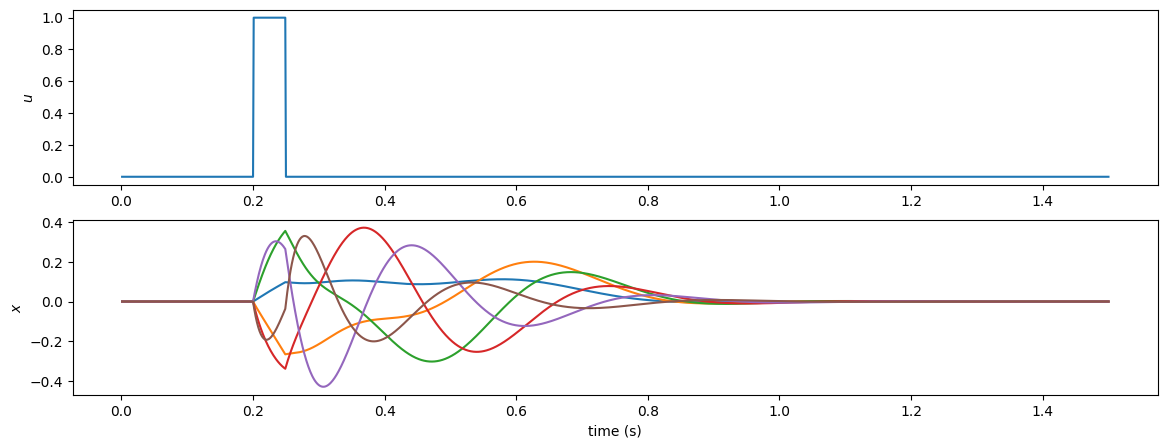

In [4]:
plt.figure(figsize=(14,5))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('$u$')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_ldn])
plt.ylabel('$x$')
plt.xlabel('time (s)')
plt.show()

Okay, so this weird differential equation does something over time based on an input.  But how well is it representing that pulse?  Let's try extracting some information out of the LDN.  In particular, let's extract what it thinks the value was 0.25 seconds ago.  Since theta is 0.5s, 0.25s ago is half way through our window.  We can ask the LDN for the weights that will decode that information, which is just the value of the Legendre polynomials at that point.

In [6]:
theta = 0.5
q = 6

model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: 1 if 0.2<t<0.25 else 0)
    #stim = nengo.Node(nengo.processes.WhiteSignal(high=3, period=3))
    
    ldn = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim, ldn, synapse=None)
    
    delayed_output = nengo.Node(None, size_in=1)
    nengo.Connection(ldn, delayed_output, transform=ldn.output.get_weights_for_delays([0.5]))
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_delayed_output = nengo.Probe(delayed_output)
sim = nengo.Simulator(model)
with sim:
    sim.run(1.5)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


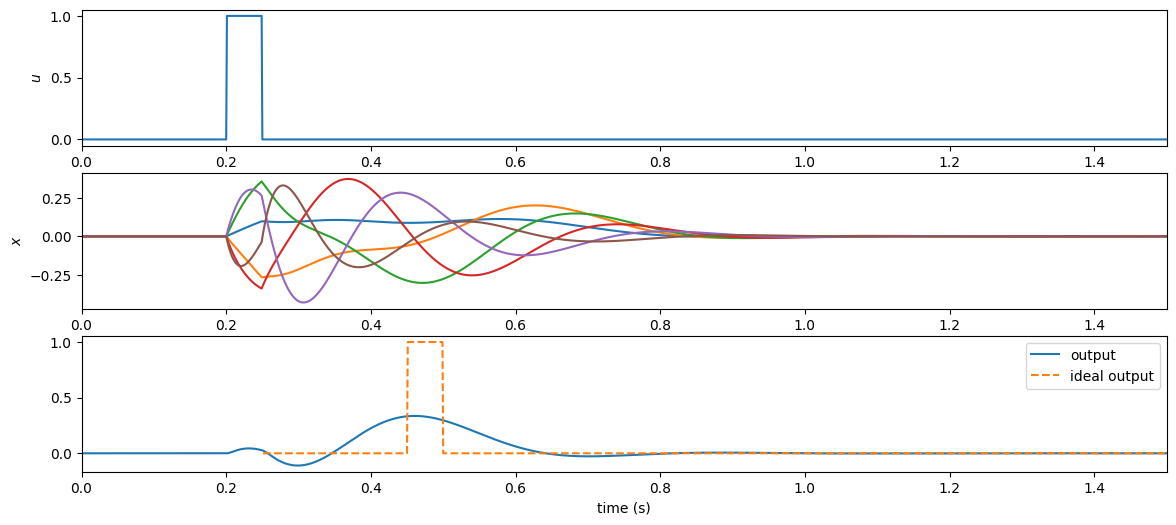

In [7]:
plt.figure(figsize=(14,6))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('$u$')
plt.xlim(0, 1.5)
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p_ldn])
plt.ylabel('$x$')
plt.xlim(0, 1.5)
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_delayed_output], label='output')
plt.plot(sim.trange()+0.25, sim.data[p_stim], ls='--', label='ideal output')
plt.xlim(0, 1.5)
plt.legend()
plt.xlabel('time (s)')
plt.show()

Hmm, it sort of works, but it's not great.  This is probably because we're asking it to encode a pulse, which is a very high frequency signal!  Let's try increasing $q$ so it is using more legendre polynomials, and thus is encoding higher frequencies.

In [8]:
theta = 0.5
q = 20

model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: 1 if 0.2<t<0.25 else 0)
    #stim = nengo.Node(nengo.processes.WhiteSignal(high=3, period=3))
    
    ldn = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim, ldn, synapse=None)
    
    delayed_output = nengo.Node(None, size_in=1)
    nengo.Connection(ldn, delayed_output, transform=ldn.output.get_weights_for_delays([0.5]))
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_delayed_output = nengo.Probe(delayed_output)
sim = nengo.Simulator(model)
with sim:
    sim.run(1.5)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


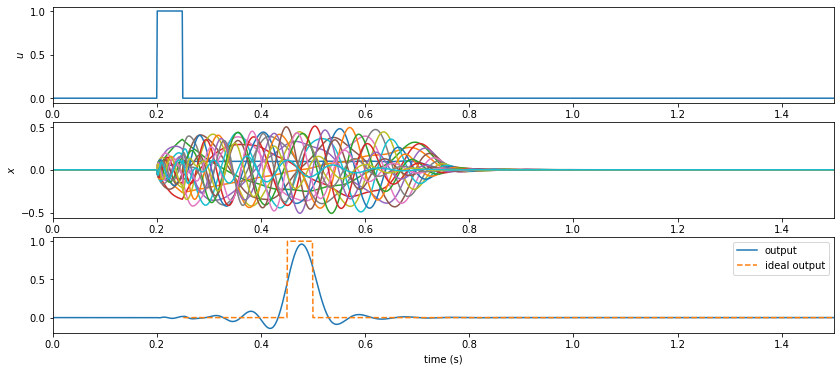

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('$u$')
plt.xlim(0, 1.5)
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p_ldn])
plt.ylabel('$x$')
plt.xlim(0, 1.5)
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_delayed_output], label='output')
plt.plot(sim.trange()+0.25, sim.data[p_stim], ls='--', label='ideal output')
plt.xlim(0, 1.5)
plt.legend()
plt.xlabel('time (s)')
plt.show()

Sweet!  If we want more accuracy, we could increase $q$ further, or decrease the window size, but this is good for now.

One other thing we could do is to take the $x$ value at a particular point in time and plot what it thinks the value is over the whole window of time. 

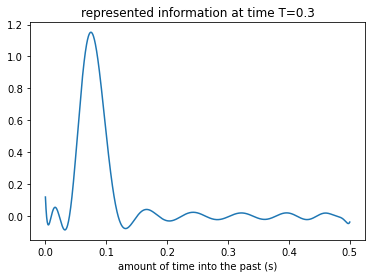

In [9]:
t_plot = 0.3
w = np.linspace(0, 1, 1000)
decoder = LDN(theta=theta, q=q).get_weights_for_delays(w)
plt.plot(w*theta, decoder.dot(sim.data[p_ldn][int(t_plot/0.001)]))
plt.xlabel('amount of time into the past (s)')
plt.title(f'represented information at time T={t_plot}')
plt.show()

We could also try feeding in a band-limited white noise signal, to see how it handles a smoother input.  In this case, we're also putting $q$ back to 6 as that's probably fine for a slowly varying signal

In [10]:
theta = 0.5
q = 6

model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(high=3, period=3))
    
    ldn = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim, ldn, synapse=None)
    
    delayed_output = nengo.Node(None, size_in=1)
    nengo.Connection(ldn, delayed_output, transform=ldn.output.get_weights_for_delays([0.5]))
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_delayed_output = nengo.Probe(delayed_output)
sim = nengo.Simulator(model)
with sim:
    sim.run(1.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

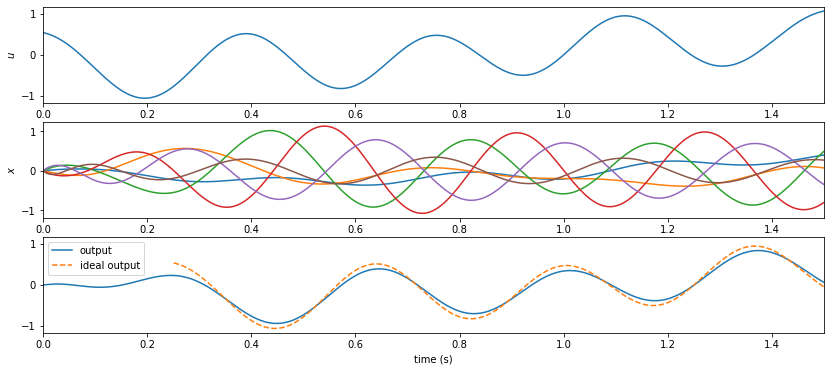

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('$u$')
plt.xlim(0, 1.5)
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p_ldn])
plt.ylabel('$x$')
plt.xlim(0, 1.5)
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[p_delayed_output], label='output')
plt.plot(sim.trange()+0.25, sim.data[p_stim], ls='--', label='ideal output')
plt.xlim(0, 1.5)
plt.legend()
plt.xlabel('time (s)')
plt.show()

## Looking for patterns

We can decode a particular point in time, but what if we want to search for a pattern that occurs across time?  Well, one thing we could do is to decode lots of different points in time and weight them by different amounts.  Since everything is linear, we can add all this decoding up and it ends up being just one set of decoding weights.  That is, detecting the presence of a pattern is the same amount of computational complexity as decoding out one particular point in time!

For example, let's look for this particular pattern below:

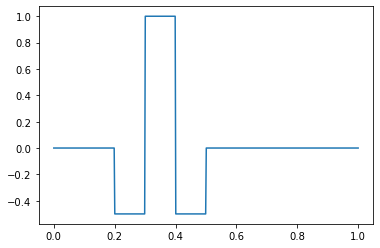

In [12]:
t = np.linspace(0, 1, 500)
v = np.zeros(500)
v[100:150] = -0.5
v[150:200] = 1.0
v[200:250] = -0.5
plt.plot(t, v)

To find this pattern, we just compute the weighted sum of the decoding valuess for each point in time

In [13]:
theta = 0.5
q = 20
w = LDN(theta=theta, q=q).get_weights_for_delays([t])
d = w.T.dot(v)*0.02    # with a scaling factor to keep the resulting magnitude reasonable
print(d)

[ 0.00000000e+00  4.44089210e-18 -6.02407219e-02  9.05421672e-02
  4.47589992e-02 -2.02360567e-01  9.21100624e-02  2.09133753e-01
 -2.62235780e-01 -6.68216137e-02  3.28245090e-01 -1.35933042e-01
 -2.36061721e-01  2.61874664e-01  5.86030696e-02 -2.47880972e-01
  8.26630470e-02  1.42626110e-01 -1.24708006e-01 -3.90194061e-02]


Now let's see if this works.  We'll generate a pattern of inputs to feed into the system so we can see how it behaves for inputs close to, but not quite, the same as the desired pattern.

In [14]:
theta = 0.5
q = 20

pattern = [0,-0.4,1.0,-0.4,0,0,0,1.0,0,0,0,-0.4,1.0,0,0,0]

model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.PresentInput(pattern, presentation_time=0.05))
    
    ldn = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim, ldn, synapse=None)
    
    detect = nengo.Node(None, size_in=1)
    nengo.Connection(ldn, detect, transform=[d])
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_detect = nengo.Probe(detect)
sim = nengo.Simulator(model)
with sim:
    sim.run(1.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

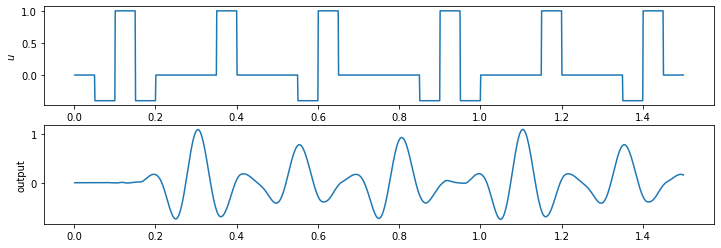

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim])
plt.ylabel('$u$')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_detect])
plt.ylabel('output')
plt.show()

Notice that the output reaches its highest value when the correct pattern appears, but it will get close to that peak for similar patterns.

Also, note that the output peaks *after* the pattern is presented.  That's because we're specifically looking for that pattern *at a particular time in the past*.  

It is also worth noting that, so far, everything we've done has been completely linear.  In fact, there's another name for what we've done here: the system is computing the convolution of our input with the desired pattern.

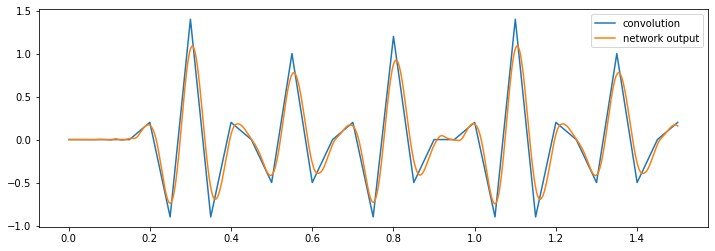

In [16]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), np.convolve(sim.data[p_stim][:,0], v)[:1500]*0.02, label='convolution')
plt.plot(sim.trange(), sim.data[p_detect], label='network output')
plt.legend()
plt.show()

## Adding a non-linearity: the full LMU

So the system so far can be useful if we want to do some linear operation on our input, such as convolving it with any arbitrary pattern.  But, it'd be good to do non-linear things as well.

The easiest way to add a non-linearity is to just take the output from the LDN and feed it into a layer of neurons.  We call this system an LMU.  We can now use whatever methods we feel like to train the non-linear part, but importantly we don't have to train the linear part.  This means we just have to do feed-forward training, which can be much more efficient than doing recurrent training.

As an example, let's build a network that can detect whether the input is a 1Hz sine wave or a 2Hz sine wave.  To do this, we start by generating some training data.

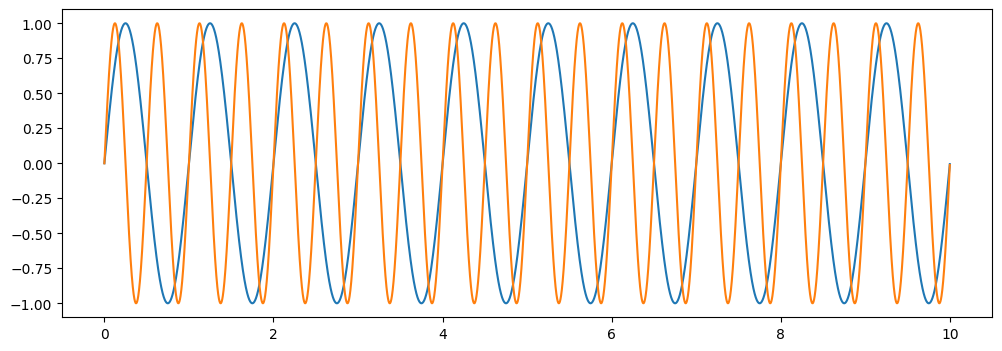

In [5]:
dt = 0.001
t = np.arange(10000)*dt
stim1 = np.sin(t*2*np.pi).reshape(-1,1)
stim2 = np.sin(t*2*np.pi*2).reshape(-1,1)

plt.figure(figsize=(12,4))
plt.plot(t, stim1)
plt.plot(t, stim2)

Now we feed those signals into the LDN.  Since this is the data that would be fed into the non-linear neural network part, this is the actual training data for our system.  

Fortunately, `nengo.Process` objects have a nice helper function `apply` that does this for us.

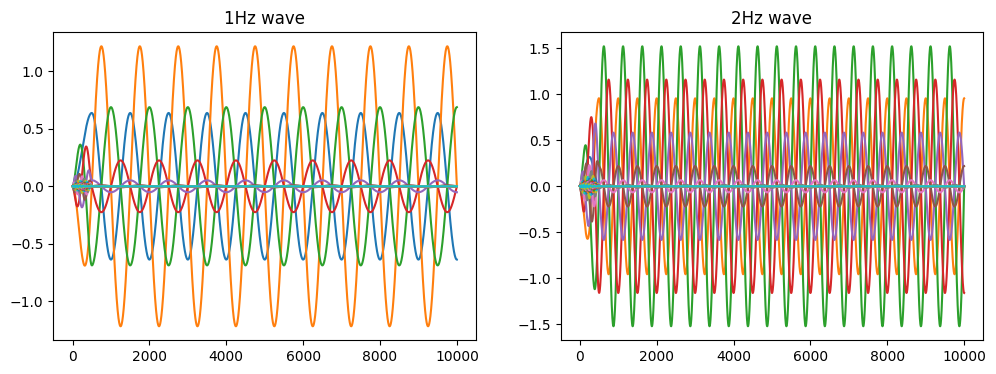

In [13]:
theta = 0.5
q = 20
x1 = LDN(theta=theta, q=q).apply(stim1) # Encode the data in compressed form
x2 = LDN(theta=theta, q=q).apply(stim2)


plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(x1)
plt.title('1Hz wave')
plt.subplot(1, 2, 2)
plt.plot(x2)
plt.title('2Hz wave')
plt.show()

Now we collect this data together so we can use it as training data in Nengo.  This requires us to make an `eval_points` array (the inputs to the network) and a `targets` array (the corresponding desired outputs).

In [6]:
eval_points = np.vstack([x1, x2]) #Training data is the compressed encoding
targets = np.hstack([np.ones(len(x1)), -np.ones(len(x2))]).reshape(-1,1)

Now we build our model again and this time we add some neurons and tell Nengo to decode out our desired function using this training data.  Note that this is the same as the normal nengo approach of specifying a `function` when we make a `Connection`, but here we're specifying the exact data to train with, rather than giving a function.

In [13]:
import nengo_loihi
nengo_loihi.set_defaults()
model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t) if t<4 else np.sin(2*np.pi*t*2))
    
    ldn = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim, ldn, synapse=None)
    
    neurons = nengo.Ensemble(n_neurons=500, dimensions=q, neuron_type=nengo.LIF())
    nengo.Connection(ldn, neurons)
    
    category = nengo.Node(None, size_in=1)
    nengo.Connection(neurons, category, eval_points=eval_points, function=targets)
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_category = nengo.Probe(category, synapse=0.01)

sim = nengo_loihi.Simulator(model)
with sim:
    sim.run(8)

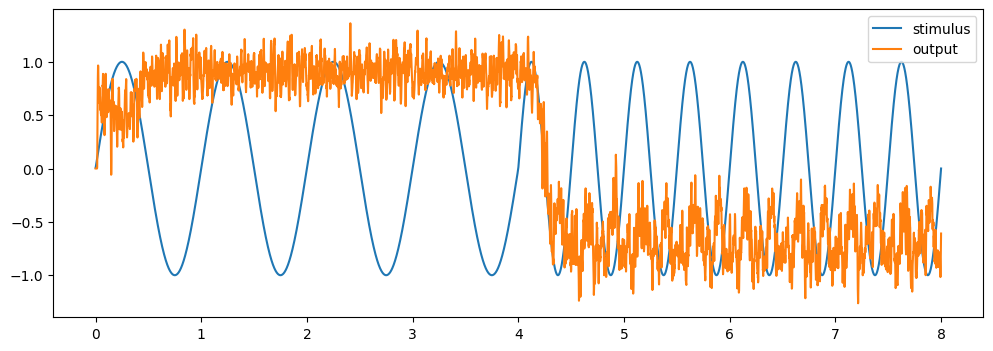

In [14]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_stim], label='stimulus')
plt.plot(sim.trange(), sim.data[p_category], label='output')
plt.legend()
plt.show()

It works!  For more complex situations, we'd probably want to generate a lot more training data to cover different inputs, but we'd use the same approach as shown here.  We could also have multiple outputs, rather than just one.

## Coincidence detection

The approach shown above will work for any function you want to decode, as long as you have enough neurons.  However, in some situations you may have more specific information about the function you're trying to get it to do, and that may let you design the system to work with fewer neurons.

For example, let's say we want to do coincidence detection across two separate inputs.  In particular, maybe we have two inputs (fed into two separate LDNs), and we want to know whether there's a particular temporal pattern between them.  In particular, let's look for two pulses, one of them 50ms after the other.

We could do this the same way as the above example: take all the data from both LMUs, feed them into a layer of neurons, and train it to find the pattern we want using a bunch of training data.  As an alternative, however, we can use what we know of the system to make choices about the network that will make it more efficient.  

In this case, we know that there are only certain point in time that are important.  So we can decode out just those two points in time and feed that into the network.   Furthermore, we can decide what operation we might want to do on those two points in time.  In this case, I've decided to just compute the product.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

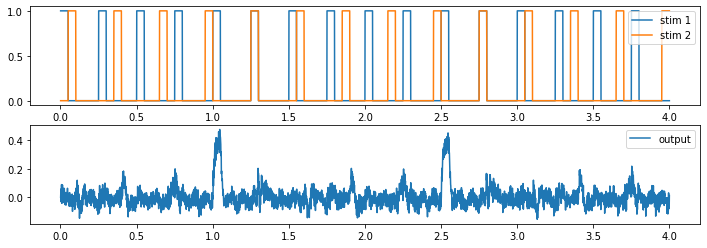

In [22]:
model = nengo.Network()
with model:
    stim1 = nengo.Node(nengo.processes.PresentInput([1,0,0,0,0], presentation_time=0.05))
    stim2 = nengo.Node(nengo.processes.PresentInput([0,1,0,0,0,0], presentation_time=0.05))
    
    ldn1 = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim1, ldn1, synapse=None)

    ldn2 = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim2, ldn2, synapse=None)
    
    n = nengo.Ensemble(n_neurons=50, dimensions=2)
    product_output = nengo.Node(None, size_in=1)
    nengo.Connection(n, product_output, function=lambda x: x[0]*x[1], synapse=None)
    nengo.Connection(ldn1, n[0], synapse=None, transform=ldn.output.get_weights_for_delays([0]))
    nengo.Connection(ldn2, n[1], synapse=None, transform=ldn.output.get_weights_for_delays([0.1]))
    
    p_stim1 = nengo.Probe(stim1)
    p_stim2 = nengo.Probe(stim2)
    p_product = nengo.Probe(product_output, synapse=0.01)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(4)
    
plt.figure(figsize=(12,4))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim1], label='stim 1')
plt.plot(sim.trange(), sim.data[p_stim2], label='stim 2')
plt.legend()
plt.subplot(2, 1, 2)

plt.plot(sim.trange(), sim.data[p_product], label='output')
plt.legend()
plt.show()

This nicely picks out the peaks, and only uses 50 neurons.


If we want to optimize this even more, Nengo has a built-in network for computing a product.  This network actually splits things out into two networks and uses the $xy=((x+y)^2-(x-y)^2)/4$ identity to optimize the neurons.  This lets us get away with even fewer neurons.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

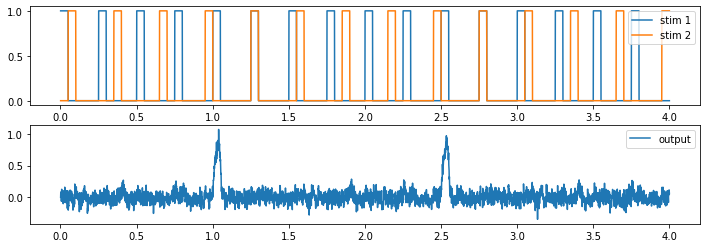

In [23]:
model = nengo.Network()
with model:
    stim1 = nengo.Node(nengo.processes.PresentInput([1,0,0,0,0], presentation_time=0.05))
    stim2 = nengo.Node(nengo.processes.PresentInput([0,1,0,0,0,0], presentation_time=0.05))
    
    ldn1 = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim1, ldn1, synapse=None)

    ldn2 = nengo.Node(LDN(theta=theta, q=q))
    nengo.Connection(stim2, ldn2, synapse=None)
    
    product = nengo.networks.Product(n_neurons=20, dimensions=1)
    nengo.Connection(ldn1, product.input_a, synapse=None, transform=ldn.output.get_weights_for_delays([0.]))
    nengo.Connection(ldn2, product.input_b, synapse=None, transform=ldn.output.get_weights_for_delays([0.1]))
    
    p_stim1 = nengo.Probe(stim1)
    p_stim2 = nengo.Probe(stim2)
    p_product = nengo.Probe(product.output, synapse=0.01)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(4)
    
plt.figure(figsize=(12,4))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_stim1], label='stim 1')
plt.plot(sim.trange(), sim.data[p_stim2], label='stim 2')
plt.legend()
plt.subplot(2, 1, 2)

plt.plot(sim.trange(), sim.data[p_product], label='output')
plt.legend()
plt.show()

It is important to point out here that this final network has exactly the same overall structure as the network where we just fed all the LDN data into a layer of neurons.  It just uses fewer neurons, and has a different way of generating the connection weights.  We can look at the network model in the nengo GUI to confirm this.

Click on the "Product" box to look inside it, and then click on the "sq1" and "sq2" boxes.  We can see the only non-linearities are the two pools of neurons in sq1 and sq2.  All the other dots and lines are just linear matrix operations.  So if we want we can multiply all of those matrices together and just get the direct connection weights from ldn1 and ldn2 to our neurons (which we can also think of as a single layer). 

In [24]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)